In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
# create datasets
def generate_in_distribution_data(n, mu, pi_in):
    n_1 = round(n*pi_in)
    n_0 = round(n*(1-pi_in))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    X_0 = np.random.multivariate_normal(mu_0, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(mu_1, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, pi_out, theta):
    n_1 = round(n*pi_out)
    n_0 = round(n*(1-pi_out))
    mu_1 = np.array([mu, 0])
    mu_0 = -mu_1
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, s), (-s, c)))
    X_0 = np.random.multivariate_normal(np.matmul(R, mu_0.T).T, np.identity(2), n_0).T
    X_1 = np.random.multivariate_normal(np.matmul(R, mu_1.T).T, np.identity(2), n_1).T
    X = np.concatenate((X_0, X_1), axis=-1)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

## Multi-Head LDA

In [9]:
def compute_multihead_decision_rule_1(X_in, Y_in, X_out, Y_out, return_target_hypothesis=False):

    X_in_0 = X_in[:, Y_in==0]
    X_in_1 = X_in[:, Y_in==1]
    X_out_0 = X_out[:, Y_out==0]
    X_out_1 = X_out[:, Y_out==1]

    ## combination 1
    X_0 = np.concatenate((X_in_0, X_out_0), axis=-1)
    X_1 = np.concatenate((X_in_1, X_out_1), axis=-1)
    X_1_bar = np.nan_to_num(np.mean(X_1, axis=-1, keepdims=True))
    X_0_bar = np.nan_to_num(np.mean(X_0, axis=-1, keepdims=True))
    X_centered = X_0 - X_0_bar
    S_0 = (1/np.size(X_0, -1))*np.matmul(X_centered, X_centered.T)
    X_centered = X_1 - X_1_bar
    S_1 = (1/np.size(X_1, -1))*np.matmul(X_centered, X_centered.T)

    omega_comb_1 = np.matmul(np.linalg.inv(S_0 + S_1), X_1_bar - X_0_bar)

    # combination 2
    X_0 = np.concatenate((X_in_0, X_out_1), axis=-1)
    X_1 = np.concatenate((X_in_0, X_out_0), axis=-1)
    X_1_bar = np.nan_to_num(np.mean(X_1, axis=-1, keepdims=True))
    X_0_bar = np.nan_to_num(np.mean(X_0, axis=-1, keepdims=True))
    X_centered = X_0 - X_0_bar
    S_0 = (1/np.size(X_0, -1))*np.matmul(X_centered, X_centered.T)
    X_centered = X_1 - X_1_bar
    S_1 = (1/np.size(X_1, -1))*np.matmul(X_centered, X_centered.T)

    omega_comb_2 = np.matmul(np.linalg.inv(S_0 + S_1), X_1_bar - X_0_bar)

    # estimate threshold
    X_in_projected = np.matmul(omega_comb_1.T, X_in).squeeze()
    c_in_comb_1 = (np.mean(X_in_projected[Y_in == 0]) + np.mean(X_in_projected[Y_in == 1]))/2

    X_in_projected = np.matmul(omega_comb_2.T, X_in).squeeze()
    c_in_comb_2 = (np.mean(X_in_projected[Y_in == 0]) + np.mean(X_in_projected[Y_in == 1]))/2

    return omega_comb_1, omega_comb_2, c_in_comb_1, c_in_comb_2

def compute_multihead_decision_rule_2(X_in, Y_in, X_out, Y_out, return_target_hypothesis=False):

    X_in_0 = X_in[:, Y_in==0]
    X_in_1 = X_in[:, Y_in==1]
    X_out_0 = X_out[:, Y_out==0]
    X_out_1 = X_out[:, Y_out==1]

    ## decision rule for in-task
    X_0_bar = np.nan_to_num(np.mean(X_in_0, axis=-1, keepdims=True))
    X_1_bar = np.nan_to_num(np.mean(X_in_1, axis=-1, keepdims=True))
    X_centered = X_in_0 - X_0_bar
    S_0 = (1/np.size(X_in_0, -1))*np.matmul(X_centered, X_centered.T)
    X_centered = X_in_1 - X_1_bar
    S_1 = (1/np.size(X_in_1, -1))*np.matmul(X_centered, X_centered.T)

    omega_in = np.matmul(np.linalg.inv(S_0 + S_1), X_1_bar - X_0_bar)

    ## decision rule for out-task
    X_0_bar = np.nan_to_num(np.mean(X_out_0, axis=-1, keepdims=True))
    X_1_bar = np.nan_to_num(np.mean(X_out_1, axis=-1, keepdims=True))
    X_centered = X_out_0 - X_0_bar
    S_0 = (1/np.size(X_out_0, -1))*np.matmul(X_centered, X_centered.T)
    X_centered = X_out_1 - X_1_bar
    S_1 = (1/np.size(X_out_1, -1))*np.matmul(X_centered, X_centered.T)

    omega_out = np.matmul(np.linalg.inv(S_0 + S_1), X_1_bar - X_0_bar)

    # averge the projection vectors
    omega = (omega_in + omega_out)/2

    # estimate threshold
    X_in_projected = np.matmul(omega.T, X_in).squeeze()
    c_in = (np.mean(X_in_projected[Y_in == 0]) + np.mean(X_in_projected[Y_in == 1]))/2

    return omega, c_in

def compute_multihead_decision_rule_3(X_in, Y_in, X_out, Y_out):
    N = len(Y_in) + len(Y_out)

    X_in_0 = X_in[:, Y_in == 0]
    X_in_0_bar = np.nan_to_num(np.mean(X_in_0, axis=-1, keepdims=True))
    X_centered = X_in_0 - X_in_0_bar
    S_w_in_0 = np.matmul(X_centered, X_centered.T)

    X_in_1 = X_in[:, Y_in == 1]
    X_in_1_bar = np.nan_to_num(np.mean(X_in_1, axis=-1, keepdims=True))
    X_centered = X_in_1 - X_in_1_bar
    S_w_in_1 = np.matmul(X_centered, X_centered.T)

    X_out_0 = X_out[:, Y_out == 0]
    X_out_0_bar = np.nan_to_num(np.mean(X_out_0, axis=-1, keepdims=True))
    X_centered = X_out_0 - X_out_0_bar
    S_w_out_0 = np.matmul(X_centered, X_centered.T)

    X_out_1 = X_out[:, Y_out == 1]
    X_out_1_bar = np.nan_to_num(np.mean(X_out_1, axis=-1, keepdims=True))
    X_centered = X_out_1 - X_out_1_bar
    S_w_out_1 = np.matmul(X_centered, X_centered.T)

    S_w = (S_w_in_0 + S_w_in_1 + S_w_out_0 + S_w_out_1)/N

    # S_b according to "A generalization of LDA in MLE framework"
    X = np.concatenate((X_in, X_out), axis=-1)
    X_bar = np.mean(X, axis=-1, keepdims=True)
    X_centered = X - X_bar
    S_b = np.matmul(X_centered, X_centered.T)/N

    # S_b according to Bishop's Book + other sources
    m_k = np.concatenate((X_in_0_bar, X_in_1_bar, X_out_0_bar, X_out_1_bar), axis=-1)
    m_k_centered = m_k - np.mean(m_k, axis=-1, keepdims=True)
    S_bn = len(Y_in[Y_in==0])*np.matmul(m_k_centered[:, [0]], m_k_centered[:, [0]].T) +\
           len(Y_in[Y_in==1])*np.matmul(m_k_centered[:, [1]], m_k_centered[:, [1]].T) +\
           len(Y_out[Y_out==0])*np.matmul(m_k_centered[:, [2]], m_k_centered[:, [2]].T) +\
           len(Y_out[Y_out==1])*np.matmul(m_k_centered[:, [3]], m_k_centered[:, [3]].T)
    S_bn /= N

    # estimate projection vector
    e, v = np.linalg.eig(np.matmul(np.linalg.inv(S_w), S_bn))
    omega = v[:, np.argmax(e)].reshape(2, 1)
    
    # estimate threshold
    X_in_projected = np.matmul(omega.T, X_in).squeeze()
    c_in = (np.mean(X_in_projected[Y_in == 0]) + np.mean(X_in_projected[Y_in == 1]))/2
    
    return omega, c_in

def compute_empirical_risk(X, Y, omega, c, method='1'):
    Y_pred = (np.matmul(omega.T, X) > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def visualize_projection_vector(n, m, theta, mu=3, pi_in=0.5, pi_out=0.5):
    X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
    X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
    omega, c = compute_multihead_decision_rule(X_in, Y_in, X_out, Y_out)

    m = omega[1]/omega[0]
    x = np.arange(-5, 5, 0.1)
    y = m*x

    fig, ax = plt.subplots()
    ax.scatter(X_in[:, Y_in==0][0, :], X_in[:, Y_in==0][1, :], c='b')
    ax.scatter(X_in[:, Y_in==1][0, :], X_in[:, Y_in==1][1, :], c='b')
    ax.scatter(X_out[:, Y_out==0][0, :], X_out[:, Y_out==0][1, :], c='r')
    ax.scatter(X_out[:, Y_out==1][0, :], X_out[:, Y_out==1][1, :], c='r')
    ax.plot(x, y, 'k')
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 3,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 45, 90],
    m_sizes = np.arange(0, 21, 1),
    reps = 1000,
    method = '1'
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, pi_in)
            
            for theta in Theta:
                X_out, Y_out = generate_out_distribution_data(m, mu, pi_out, theta)
                if method == '1':
                    omega1, omega2, c1, c2 = compute_multihead_decision_rule_1(X_in, Y_in, X_out, Y_out)
                    df.at[i, str(theta)] = np.minimum(compute_empirical_risk(X_test, y_test, omega1, c1), compute_empirical_risk(X_test, y_test, omega2, c2))
                elif method == '2':
                    omega, c = compute_multihead_decision_rule_2(X_in, Y_in, X_out, Y_out)
                    df.at[i, str(theta)] = compute_empirical_risk(X_test, y_test, omega, c)
                else:
                    omega, c = compute_multihead_decision_rule_3(X_in, Y_in, X_out, Y_out)
                    df.at[i, str(theta)] = compute_empirical_risk(X_test, y_test, omega, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Theta', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Theta", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Risk")
    ax.set_xlabel(r"$m/n, n={}$".format(n))
    # ax.set_xlim([0, 100])
    return df

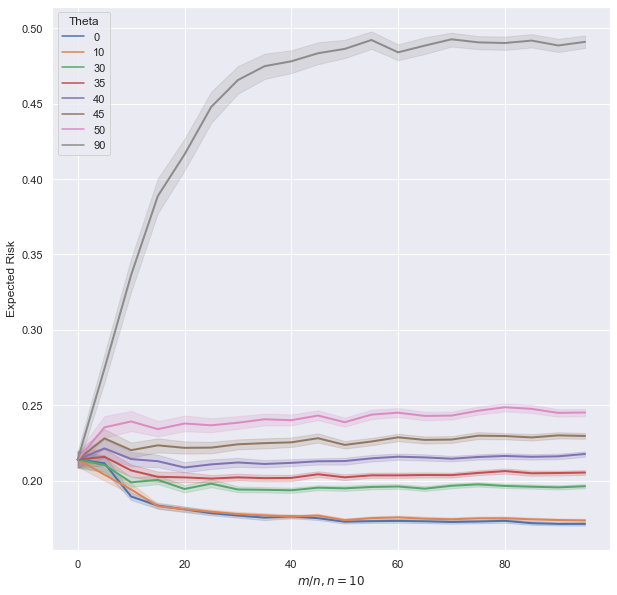

In [10]:
df = run_simulation(
    n = 10,
    n_test = 500,
    mu = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 30, 35, 40, 45, 50, 90],
    m_sizes = np.arange(0, 100, 5),
    reps = 1000,
    method=1
)

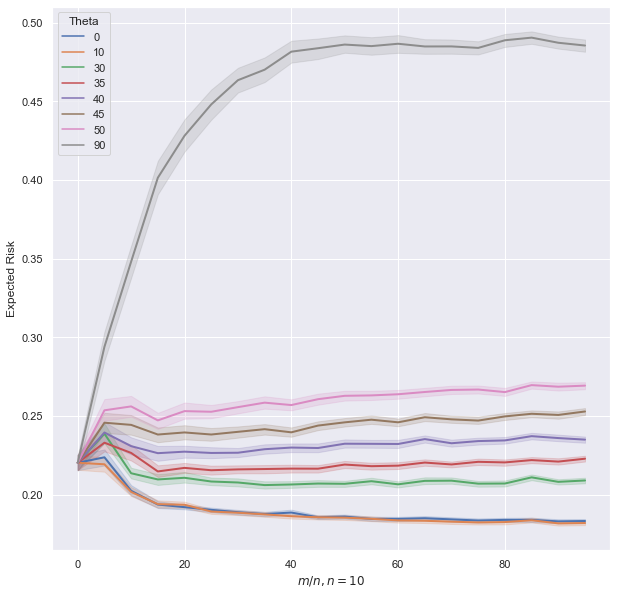

In [11]:
df = run_simulation(
    n = 10,
    n_test = 500,
    mu = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    Theta = [0, 10, 30, 35, 40, 45, 50, 90],
    m_sizes = np.arange(0, 100, 5),
    reps = 1000,
    method=2
)